# Computing energy transfers from triangular mooring array

### Coarse graining method (Aluie et, 2018; Garabato et al, 2022; Savage et al, 2025 (not published)):
The method was developed to compute energy between spatial scales.

Low-pass filter is used to extract the signal for scales larger than l. Filter is noted $\overline{.}_l$. The filter used must respect incompressiblity, i.e $\overline{\nabla . u}_l = \nabla . \overline{u}_l$ .
incompressible Navier-Stokes equation for filtered signal is
\begin{align}
\partial_t\overline{u}_l+(\overline{u}_l . \nabla)\overline{u}_l = -\nabla\overline{p}_l - \nabla . \overline{\tau}_l(u,u)
\end{align}

with $\overline{\tau_l} = \overline{uu_l} - \overline{u}_l\overline{u}_l$, the subgrid/subfilter stress

KE budget scales > l:
\begin{align}
\partial_t(\frac{\vert\overline{u_l}\vert^2}{2})+\partial_j[(\frac{\vert\overline{u_l}\vert^2}{2}+\overline{p})\overline{u}_j+\overline{u}_i\overline{\tau}_{ij}-\nu\partial_j(\frac{\vert\overline{u_l}\vert^2}{2})] = -\Pi_l-\nu\vert\nabla\overline{u}\vert^2
\end{align}

The energy transfer term, $\Pi_l$, accounts for the nonlinear interactions leading to energy transferring from scales larger than l to smaller scales:
\begin{align}
\Pi_l(\vec{x}) = - \overline{S_l}:\overline{\tau_l}(\vec{u},\vec{u})\\
\overline{S_l} = (\nabla\overline{u_l}+\nabla\overline{u_l}^T)/2 \\
\end{align}

It accounts for the large-scale strain tensor acting against subfilter scale stress.

\begin{align}
\Pi_l(\vec{x},t) = -\frac{1}{2}(\nabla_h\overline{u_{hl}}+\nabla_h\overline{u_{hl}}^T):(\overline{u_hu_{hl}}-\overline{u}_{hl} \overline{u}_{hl})
\end{align}

Extension of the theory for energy transfers along frequencies:

\begin{align}
\Pi_\omega=-\frac{1}{2}\begin{pmatrix}2\partial_x u & \partial_y u + \partial_x v \\ \partial_y u + \partial_x v & 2\partial_y v \end{pmatrix} : \begin{pmatrix}\overline{u^2}-\overline{u}^2 & \overline{uv}-\overline{u}\overline{v} \\ \overline{vu}-\overline{v}\overline{u} & \overline{v^2}-\overline{v}^2 \end{pmatrix}\\      
\Pi_\omega=-[(\overline{u^2}-\overline{u}^2)\partial_x u+(\overline{v^2}-\overline{v}^2)\partial_y v+(\overline{uv}-\overline{u}\overline{v})(\partial_y u+\partial_x v)]
\end{align}

If $\Pi_\omega >0$ then there is transfer of energy from low frequencies to high

If $\Pi_\omega <0$ then there is transfer of energy from high frequencies to low

Okubo-Weiss parameter: 

\begin{align}
OW=S_n^2+S^2-\zeta^2
\end{align}

If OW>0 then strain-dominated

If OW<0 the vorticity-dominated

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import signal
import niskine 

import mplniw.utils as ut
import mplniw.plot as pl
import mplniw.sigp as sp
import gsw
import pandas as pd

In [2]:
conf = niskine.io.load_config()
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'

In [3]:
alt = niskine.io.load_ssh()
alt['eke'] = 1/2 * (alt.ugosa**2 + alt.vgosa**2)
from datetime import datetime
eke = alt.eke.sel(time=slice('2019-06-01','2020-10-01'))#.plot()
_  = eke.mean('time')

In [4]:
#Combining moorings datasets

lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
moorings={}
cols=['u','v','u_filtered','v_filtered','usq','vsq','usq_filtered','vsq_filtered','uv_filtered']  # variables from which iwe need to remove NaN gaps
for mooring in [1,2,3]:
    ds = xr.open_dataset(root_dir+'M%s_lp05.nc'%mooring)  #loading filtered dataset
    mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))  #loading mixed layer depth at M1 
    ds['mld'] = mld_m1
    for V in cols:
        ds[V] = ds[V].interpolate_na('time',max_gap=pd.Timedelta(12,"h"))  #Interpolating data over gaps in time (flagged profiles)
    moorings[str(mooring)] = ds  #adding dataset to dict
    

In [5]:
#keeping the depth range common to all moorings
for mooring in ['1','2','3']:
    moorings[mooring] = moorings[mooring].where(np.isnan(moorings['3'].u)==False)
    moorings[mooring] = moorings[mooring].where((np.isnan(moorings['2'].u)==False)&(moorings['2'].count('time')>1000))

In [6]:
# Circle radius around moorings
R=gsw.distance([m1lon,m2lon],[m1lat,m2lat])/(2*np.sin(60*np.pi/180))


In [7]:
#Coordinates of the center of the mooring array 
latitudes = [m*np.pi/180 for m in [m1lat,m2lat,m3lat]]
longitudes = [m*np.pi/180 for m in [m1lon,m2lon,m3lon]]

In [8]:
sumx = np.sum(np.cos(latitudes)*np.cos(longitudes))/3
sumy = np.sum(np.cos(latitudes)*np.sin(longitudes))/3
sumz = np.sum(np.sin(latitudes))/3

In [9]:
midlon = 180*np.arctan2(sumy,sumx)/np.pi
hyp = np.sqrt(sumx*sumx+sumy*sumy)
midlat = 180*np.arctan2(sumz,hyp)/np.pi

In [10]:
import cartopy
import shapely

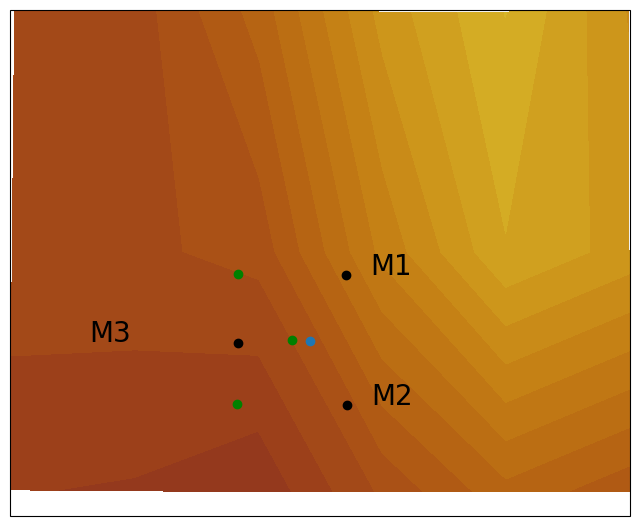

In [31]:
import cartopy.crs as ccrs
import cmocean
subplot_kws=dict(projection=ccrs.LambertConformal(central_longitude=-21.0,central_latitude=59.0),
                 facecolor='white')

fig=plt.figure(figsize=[8,8])
p = _.sel(lon=slice(-22,-20.5),lat=slice(58.7,59.4)).plot.contourf(x='lon', y='lat',
                  vmin=0, vmax=5e-2,
                  cmap=cmocean.cm.solar,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  levels=30,
                  add_labels=False,
                  add_colorbar=False)

p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());
p.axes.scatter(midlon,midlat, transform=ccrs.PlateCarree());
p.axes.scatter(m3lon,m1lat,c='g', transform=ccrs.PlateCarree());
p.axes.scatter(m3lon,m2lat,c='g', transform=ccrs.PlateCarree());
midlon_sq,midlat_sq=(m3lon+m1lon)/2,(m2lat+m1lat)/2
p.axes.scatter(midlon_sq,midlat_sq,c='g', transform=ccrs.PlateCarree());
#p.axes.plot(R*np.cos(np.linspace(0,2*np.pi,50))+midlon,R*np.sin(np.linspace(0,2*np.pi,50))+midlat,transform=ccrs.PlateCarree());
#circle_points = cartopy.geodesic.Geodesic().circle(lon=midlon, lat=midlat, radius=R, n_samples=50, endpoint=False)
#geom = shapely.geometry.Polygon(circle_points)
#p.axes.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1)


In [39]:
# Computing distance and horizontal gradients (square approximation)
dx_NE = gsw.distance([midlon_sq,m1lon],[midlat_sq,midlat_sq])
dx_SE = gsw.distance([midlon_sq,m2lon],[midlat_sq,midlat_sq])
dx_SW = gsw.distance([midlon_sq,m3lon],[midlat_sq,midlat_sq])
dx_NW = gsw.distance([midlon_sq,m3lon],[midlat_sq,midlat_sq])

dy_NE = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m1lat])
dy_SE = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m2lat])
dy_SW = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m2lat])
dy_NW = gsw.distance([midlon_sq,midlon_sq],[midlat_sq,m1lat])

In [40]:
ueast = (moorings['1'].u_filtered*dy_SE+moorings['2'].u_filtered*dy_NE)/(dy_NE+dy_SE)
veast = (moorings['1'].v_filtered*dy_SE+moorings['2'].v_filtered*dy_NE)/(dy_NE+dy_SE)

uwest = moorings['3'].u_filtered
vwest = moorings['3'].v_filtered

unorth = (moorings['1'].u_filtered*dx_NW+moorings['3'].u_filtered*dx_NE)/(dx_NE+dx_NW)
vnorth = (moorings['1'].v_filtered*dx_NW+moorings['3'].v_filtered*dx_NE)/(dx_NE+dx_NW)

usouth = (moorings['2'].u_filtered*dx_SW+moorings['3'].u_filtered*dx_SE)/(dx_SE+dx_SW)
vsouth = (moorings['2'].v_filtered*dx_SW+moorings['3'].v_filtered*dx_SE)/(dx_SE+dx_SW)

In [41]:
ux = (ueast-uwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
vx = (veast-vwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
uy = (unorth-usouth)/((dy_NE+dy_SE))
vy = (vnorth-vsouth)/((dy_NE+dy_SE))

In [42]:
RV = vx-uy

In [69]:
fc=ut.coriolis(midlat_sq)

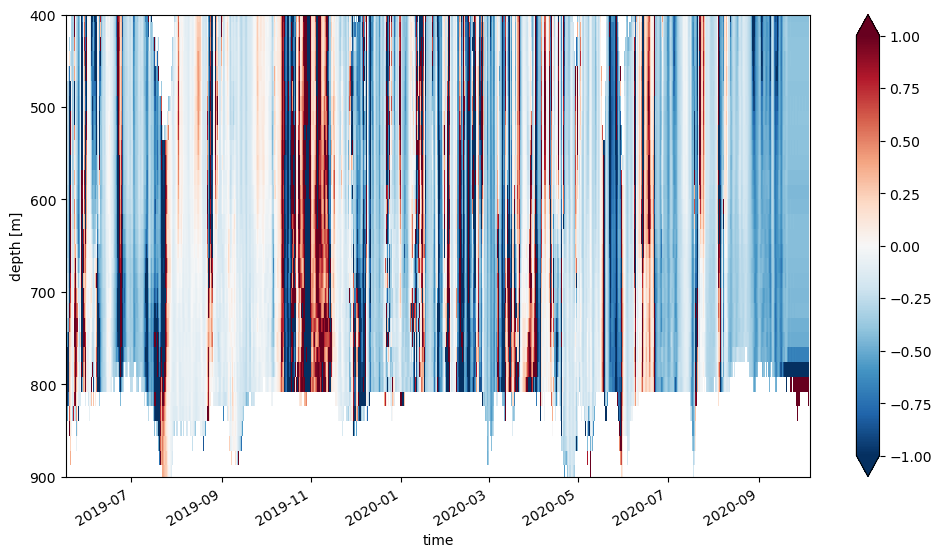

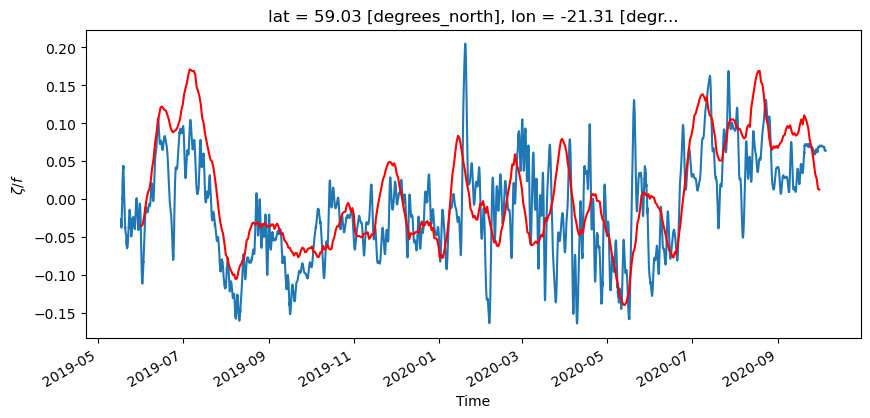

In [62]:
#Checking differences between RV and vorticity methods

vort=xr.open_dataset(root_dir+'vorticity_moorings.nc')
vort_alt=xr.open_dataset(root_dir+'vorticity_alt.nc')
fig,ax=plt.subplots(figsize=(12,6))
((RV-vort.vorticity)/vort.vorticity).plot(ax=ax,yincrease=False,ylim=(900,400),vmax=1)
plt.figure(figsize=(10,4))
(RV/fc).mean('z').plot()
(vort_alt.interp(lat=midlat_sq,lon=midlon_sq).__xarray_dataarray_variable__).plot(c='r')

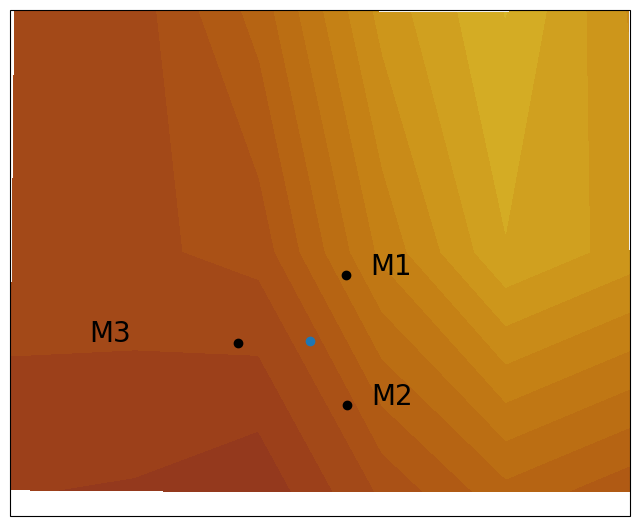

In [46]:
fig=plt.figure(figsize=[8,8])
p = _.sel(lon=slice(-22,-20.5),lat=slice(58.7,59.4)).plot.contourf(x='lon', y='lat',
                  vmin=0, vmax=5e-2,
                  cmap=cmocean.cm.solar,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  levels=30,
                  add_labels=False,
                  add_colorbar=False)

p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());
p.axes.scatter(midlon,midlat, transform=ccrs.PlateCarree());

In [48]:
# Computing distance and horizontal gradients (triangle approximation)
dx_NE = gsw.distance([midlon,m1lon],[midlat,midlat])
dx_SE = gsw.distance([midlon,m2lon],[midlat,midlat])
dx_SW = gsw.distance([midlon,m3lon],[midlat,midlat])
dx_NW = gsw.distance([midlon,m3lon],[midlat,midlat])

dy_NE = gsw.distance([midlon,midlon],[midlat,m1lat])
dy_SE = gsw.distance([midlon,midlon],[midlat,m2lat])

In [49]:
ueast = (moorings['1'].u_filtered*dy_SE+moorings['2'].u_filtered*dy_NE)/(dy_NE+dy_SE)
veast = (moorings['1'].v_filtered*dy_SE+moorings['2'].v_filtered*dy_NE)/(dy_NE+dy_SE)

uwest = moorings['3'].u_filtered
vwest = moorings['3'].v_filtered

unorth = moorings['1'].u_filtered
vnorth = moorings['1'].v_filtered

usouth = moorings['2'].u_filtered
vsouth = moorings['2'].v_filtered

ux_1 = (ueast-uwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
vx_1 = (veast-vwest)/((dx_NE+dx_SE+dx_NW+dx_SW)/2)
uy_1 = (unorth-usouth)/((dy_NE+dy_SE))
vy_1 = (vnorth-vsouth)/((dy_NE+dy_SE))

RV_1 = vx_1-uy_1

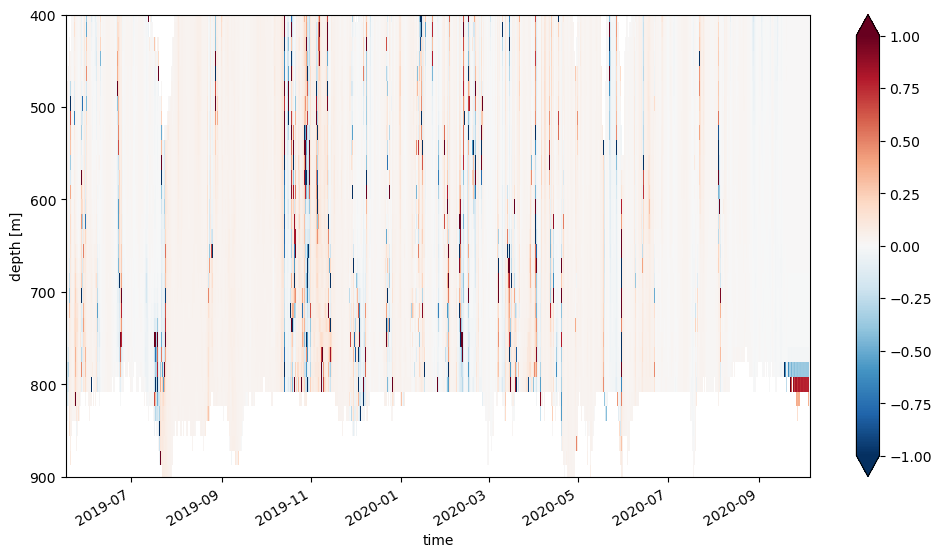

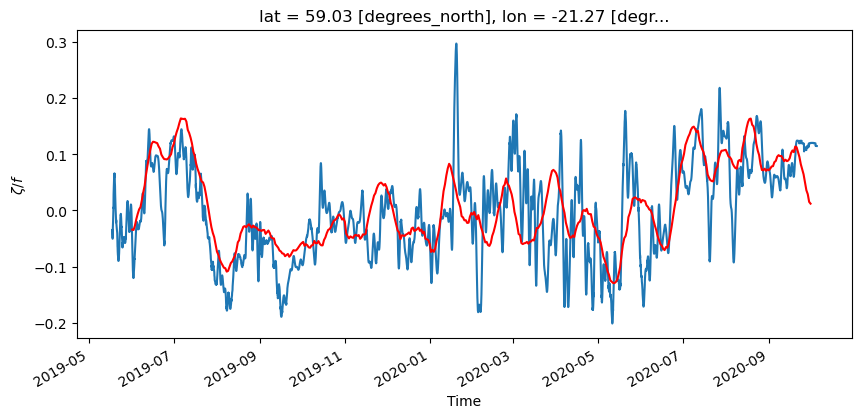

In [70]:
fc_1=ut.coriolis(midlat)
fig,ax=plt.subplots(figsize=(12,6))
((RV_1-vort.vorticity)/vort.vorticity).plot(ax=ax,yincrease=False,ylim=(900,400),vmax=1)
plt.figure(figsize=(10,4))
(RV_1/fc).mean('z').plot()
(vort_alt.interp(lat=midlat,lon=midlon).__xarray_dataarray_variable__).plot(c='r')

In [64]:
#adding lon and lat dimensions to datasets
moorings['1']=moorings['1'].assign_coords({'lat':m1lat,'lon':m1lon}).expand_dims({'lat':1,'lon':1})
moorings['2']=moorings['2'].assign_coords({'lat':m2lat,'lon':m2lon}).expand_dims({'lat':1,'lon':1})
moorings['3']=moorings['3'].assign_coords({'lat':m3lat,'lon':m3lon}).expand_dims({'lat':1,'lon':1})

In [72]:
def get_mid(moorings,mlat=midlat,mlon=midlon,col='usq'):
    """ Interpolate variable at the center  of the mooring triangular array using all moorings measurements.
    ----------------------------------------------------
    Parameters:
    moorings: dict, contains the three moorings xarray datasets
    col:str, variable to interpolate
    ----------------------------------------------------
    Returns:
    ds_mid:DataArray, interpolated variable
    """
    ds_mid=xr.merge([moorings['1'][col],moorings['2'][col],moorings['3'][col]])
    ds_mid[col]=ds_mid[col].interpolate_na(dim='time',max_gap=pd.Timedelta('1D'))
    ds_mid[col]=ds_mid[col].fillna(0).interp(lat=mlat,lon=mlon,method='slinear')
    ds_mid[col]=ds_mid[col].where(ds_mid[col]!=0)
    return ds_mid[col]

In [73]:
# interpolating needed variables to the center of the mooring array
usqf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='usq_filtered')  #filtered u squared
vsqf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='vsq_filtered')  #filtered v squared
uvf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='uv_filtered')    #filtered u*v
uf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='u_filtered')  #filtered u
vf_mid=get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='v_filtered')  #filtered v
usq_mid =get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='usq')   #raw u squared
vsq_mid =get_mid(moorings,mlat=midlat_sq,mlon=midlon_sq,col='vsq')   #raw v squared

In [74]:
# Computing energy transfer rate
Sn = ux-vy #normal components of strain
S = uy+vx #shear component of strain
RV = vx-uy  #Relative vorticity
OW = Sn**2+S**2-RV #OW parameter
P = -((usqf_mid-uf_mid**2)*ux + (vsqf_mid-vf_mid**2)*vy + (uvf_mid-uf_mid*vf_mid)*(uy+vx))

In [75]:
# interpolating needed variables to the center of the mooring array
usqf_mid_1=get_mid(moorings,col='usq_filtered')  #filtered u squared
vsqf_mid_1=get_mid(moorings,col='vsq_filtered')  #filtered v squared
uvf_mid_1=get_mid(moorings,col='uv_filtered')    #filtered u*v
uf_mid_1=get_mid(moorings,col='u_filtered')  #filtered u
vf_mid_1=get_mid(moorings,col='v_filtered')  #filtered v
usq_mid_1 =get_mid(moorings,col='usq')   #raw u squared
vsq_mid_1 =get_mid(moorings,col='vsq')   #raw v squared

In [76]:
Sn_1 = ux_1-vy_1 #normal components of strain
S_1 = uy_1+vx_1 #shear component of strain
OW_1 = Sn_1**2+S_1**2-RV_1 #OW parameter
P_1 = -((usqf_mid-uf_mid**2)*ux_1 + (vsqf_mid-vf_mid**2)*vy_1 + (uvf_mid-uf_mid*vf_mid)*(uy_1+vx_1))

Text(0.5, 1.0, 'Normalized relative vorticity')

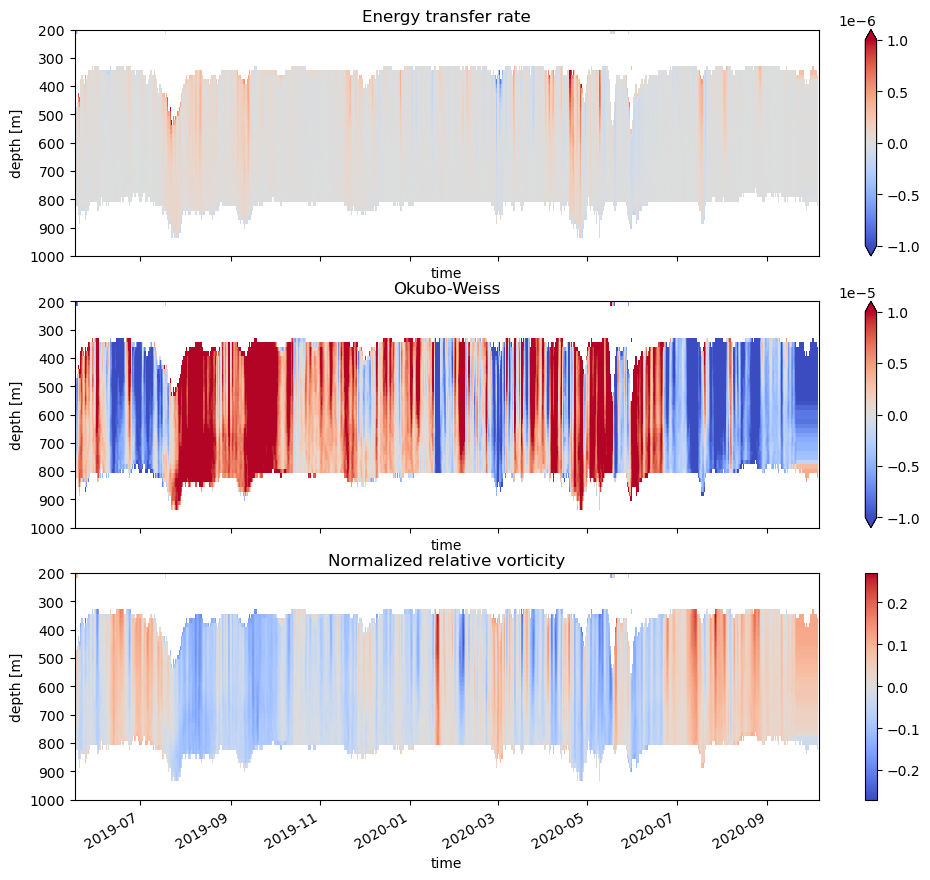

In [77]:
figs,axs=plt.subplots(3,1,figsize=(12,10),sharex=True)
ax=axs[0]
P.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-6,cmap='coolwarm')
ax.set_title('Energy transfer rate')
ax=axs[1]
OW.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-5,cmap='coolwarm')
ax.set_title('Okubo-Weiss')
ax=axs[2]
(RV/fc).plot(ax=ax,yincrease=False,ylim=(1000,200),cmap='coolwarm')
ax.set_title('Normalized relative vorticity')

Text(0.5, 1.0, 'Normalized relative vorticity')

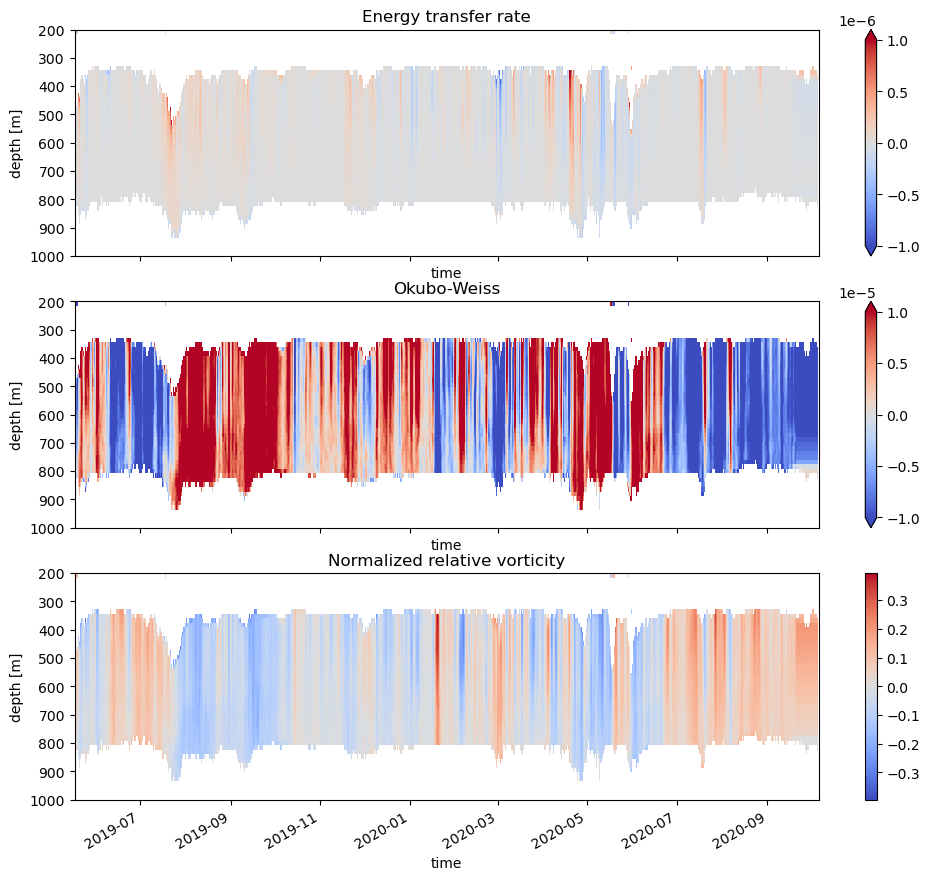

In [79]:
figs,axs=plt.subplots(3,1,figsize=(12,10),sharex=True)
ax=axs[0]
P_1.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-6,cmap='coolwarm')
ax.set_title('Energy transfer rate')
ax=axs[1]
OW_1.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-5,cmap='coolwarm')
ax.set_title('Okubo-Weiss')
ax=axs[2]
(RV_1/fc_1).plot(ax=ax,yincrease=False,ylim=(1000,200),cmap='coolwarm')
ax.set_title('Normalized relative vorticity')

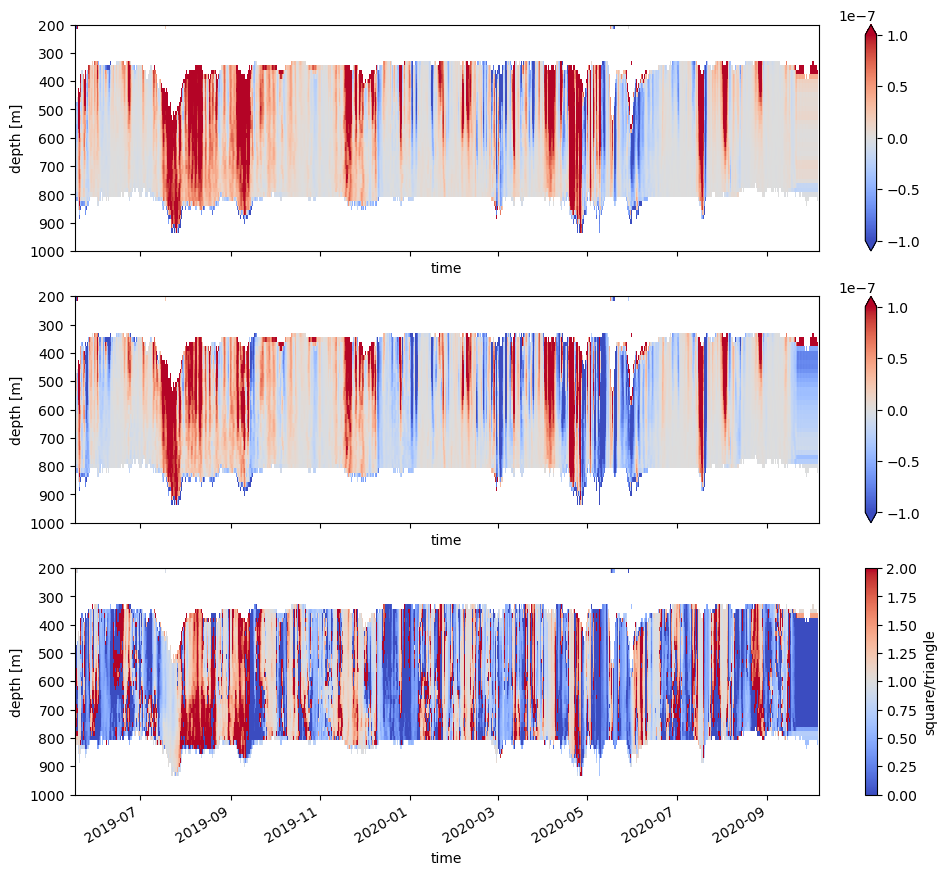

In [85]:
figs,axs=plt.subplots(3,1,figsize=(12,10),sharex=True)
ax=axs[0]
P.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-7,cmap='coolwarm')
ax=axs[1]
P_1.plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=1e-7,cmap='coolwarm')
ax=axs[2]
cs=(P/P_1).plot(ax=ax,yincrease=False,ylim=(1000,200),vmax=2,vmin=0,cmap='coolwarm',add_colorbar=False)
plt.colorbar(cs,label="square/triangle")

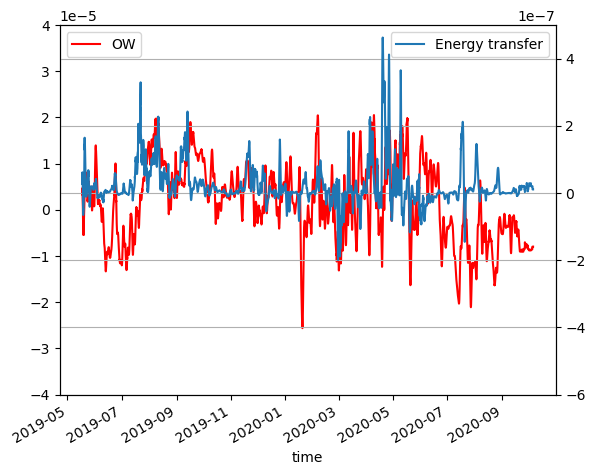

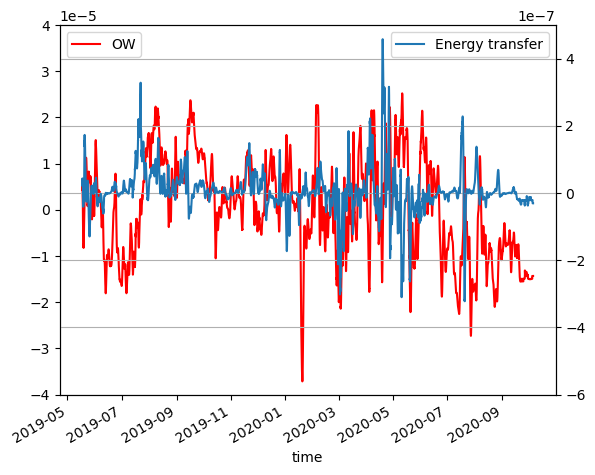

In [80]:
#Looking for a link between OW and energy transfer signs
OW.mean('z').plot(c='r',ylim=(-4.e-5,4.e-5),label='OW')
plt.legend(loc=2)
plt.twinx()
P.mean('z').plot(ylim=(-6e-7,5e-7),label='Energy transfer')
plt.grid();plt.legend(loc=1)

plt.figure()
OW_1.mean('z').plot(c='r',ylim=(-4.e-5,4.e-5),label='OW')
plt.legend(loc=2)
plt.twinx()
P_1.mean('z').plot(ylim=(-6e-7,5e-7),label='Energy transfer')
plt.grid();plt.legend(loc=1)

Text(0.5, 0.98, 'Triangle')

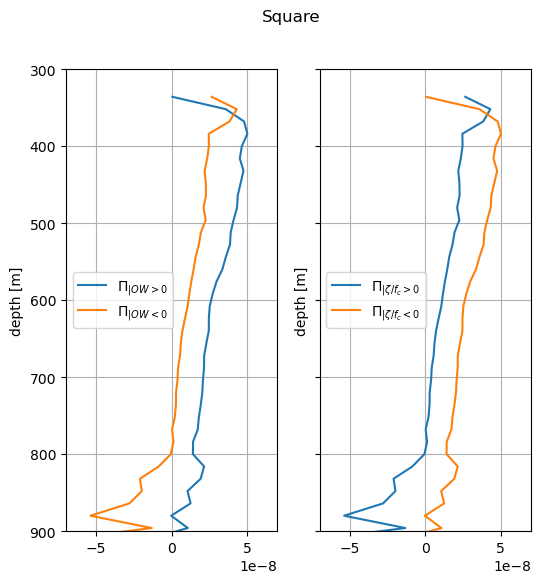

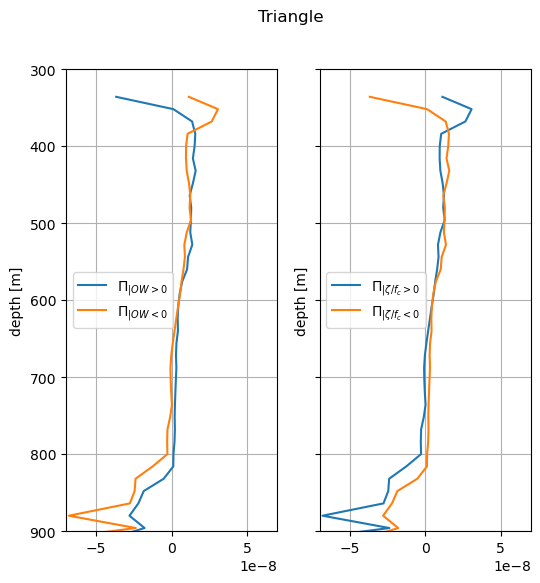

In [100]:
fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
P.where(OW>0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW>0}$')
P.where(OW<0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW<0}$')
ax[0].legend();ax[0].grid();ax[0].set_xlim(-7e-8,7e-8);ax[1].set_xlim(-7e-8,7e-8)
P.where((RV/fc)>0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c>0}$')
P.where((RV/fc)<0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c<0}$')
ax[1].legend();ax[1].grid();
fig.suptitle('Square')

fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
P_1.where(OW_1>0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW>0}$')
P_1.where(OW_1<0).mean('time').plot(ax=ax[0],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert OW<0}$')
ax[0].legend();ax[0].grid()
P_1.where((RV_1/fc_1)>0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c>0}$')
P_1.where((RV_1/fc_1)<0).mean('time').plot(ax=ax[1],y='z',yincrease=False,ylim=(900,300),label=r'$\Pi_{\vert \zeta/f_c<0}$')
ax[1].legend();ax[1].grid();ax[0].set_xlim(-7e-8,7e-8);ax[1].set_xlim(-7e-8,7e-8)
fig.suptitle('Triangle')

Text(0.5, 0.98, 'Triangle')

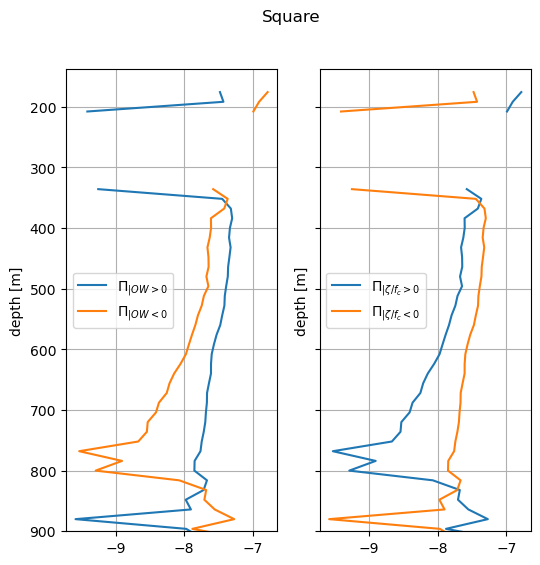

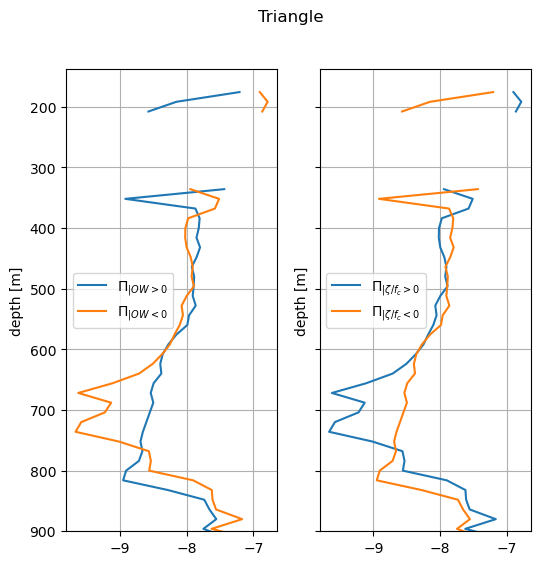

In [101]:
fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
np.log10(np.abs(P.where(OW>0).mean('time'))).plot(ax=ax[0],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert OW>0}$')
np.log10(np.abs(P.where(OW<0).mean('time'))).plot(ax=ax[0],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert OW<0}$')
ax[0].legend();ax[0].grid()
np.log10(np.abs(P.where((RV/fc)>0).mean('time'))).plot(ax=ax[1],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert \zeta/f_c>0}$')
np.log10(np.abs(P.where((RV/fc)<0).mean('time'))).plot(ax=ax[1],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert \zeta/f_c<0}$')
ax[1].legend();ax[1].grid()
fig.suptitle('Square')

fig,ax=plt.subplots(1,2,figsize=(6,6),sharey=True)
np.log10(np.abs(P_1.where(OW_1>0).mean('time'))).plot(ax=ax[0],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert OW>0}$')
np.log10(np.abs(P_1.where(OW_1<0).mean('time'))).plot(ax=ax[0],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert OW<0}$')
ax[0].legend();ax[0].grid()
np.log10(np.abs(P_1.where((RV_1/fc_1)>0).mean('time'))).plot(ax=ax[1],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert \zeta/f_c>0}$')
np.log10(np.abs(P_1.where((RV_1/fc_1)<0).mean('time'))).plot(ax=ax[1],y='z',yincrease=False,ylim=(900,None),label=r'$\Pi_{\vert \zeta/f_c<0}$')
ax[1].legend();ax[1].grid()
fig.suptitle('Triangle')

In [109]:
import seaborn as sns

(-4e-07, 4e-07)

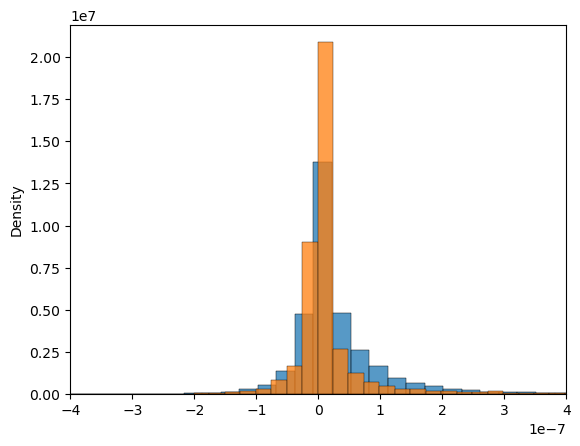

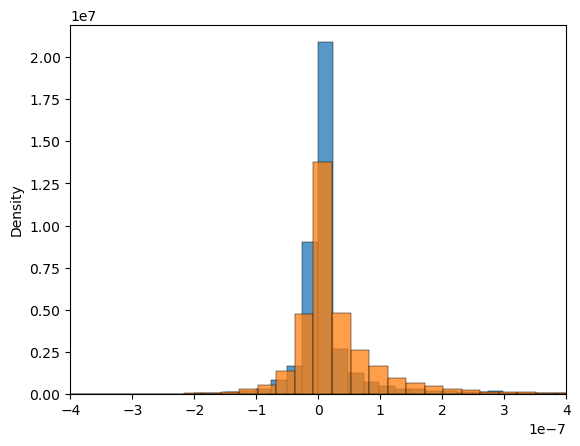

In [159]:
axes=sns.histplot(P.where(OW>0).values.flatten(),bins=100,stat='density',label='OW>0')
axes1=sns.histplot(P.where(OW<0).values.flatten(),bins=100,stat='density',label='OW<0')
axes.set_xlim(-4e-7,4e-7)

plt.figure()
axes=sns.histplot(P.where(RV>0).values.flatten(),bins=100,stat='density',label='RV>0')
axes1=sns.histplot(P.where(RV<0).values.flatten(),bins=100,stat='density',label='RV<0')
axes.set_xlim(-4e-7,4e-7)

(-4e-07, 4e-07)

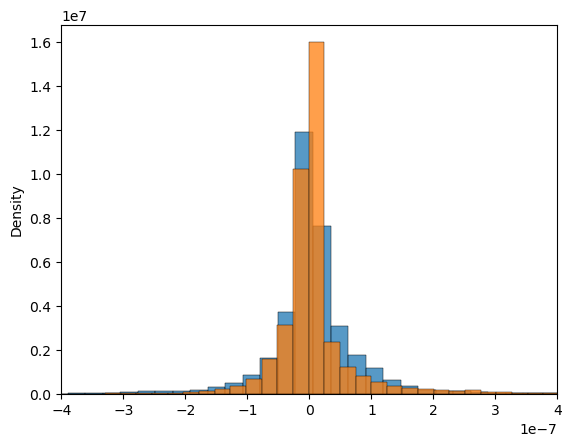

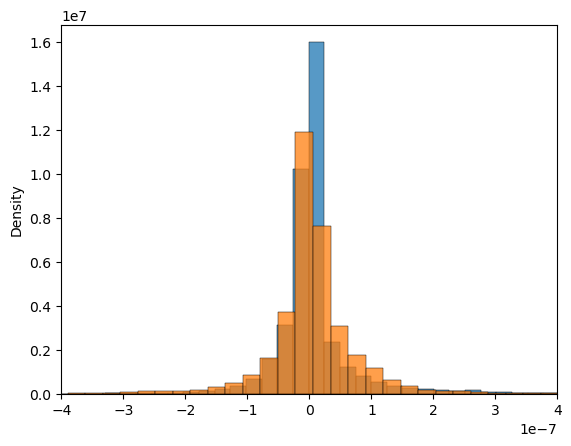

In [160]:
axes=sns.histplot(P_1.where(OW_1>0).values.flatten(),bins=100,stat='density',label='OW>0')
axes1=sns.histplot(P_1.where(OW_1<0).values.flatten(),bins=100,stat='density',label='OW<0')
axes.set_xlim(-4e-7,4e-7)

plt.figure()
axes=sns.histplot(P_1.where(RV_1>0).values.flatten(),bins=100,stat='density',label='RV>0')
axes1=sns.histplot(P_1.where(RV_1<0).values.flatten(),bins=100,stat='density',label='RV<0')
axes.set_xlim(-4e-7,4e-7)

#### Event-focused study

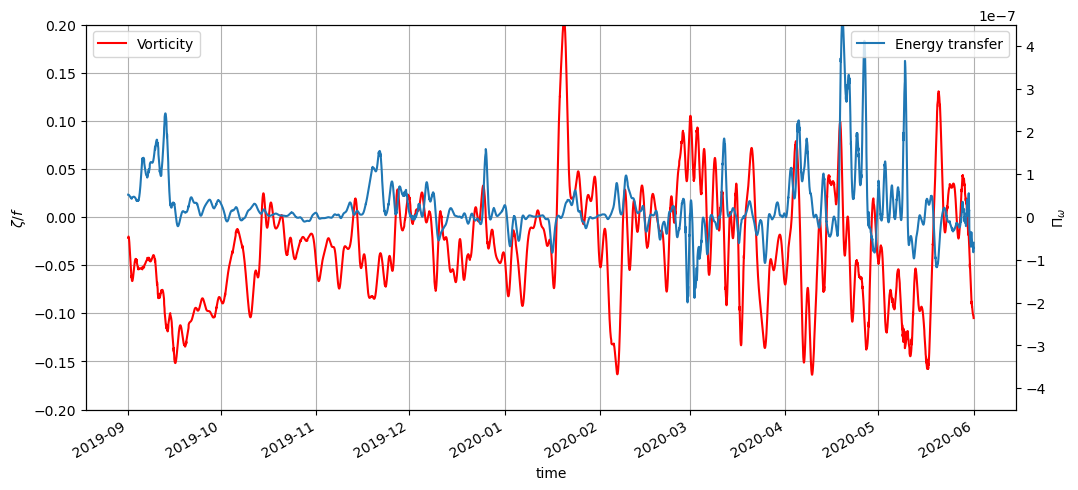

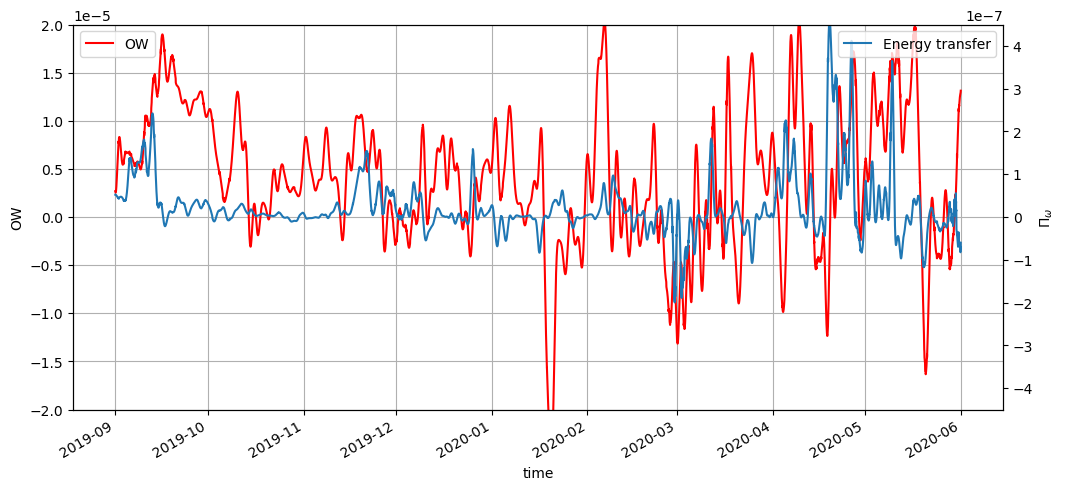

In [158]:
fig,ax=plt.subplots(figsize=(12,5))
(RV/fc).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='Vorticity')
ax.set_ylim(-0.2,0.2)
ax1=ax.twinx()
P.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-4.5e-7,4.5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'$\zeta/f$')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='upper right')

fig,ax=plt.subplots(figsize=(12,5))
(OW).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='OW')
ax.set_ylim(-2e-5,2e-5)
ax1=ax.twinx()
P.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-4.5e-7,4.5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'OW')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='upper right')

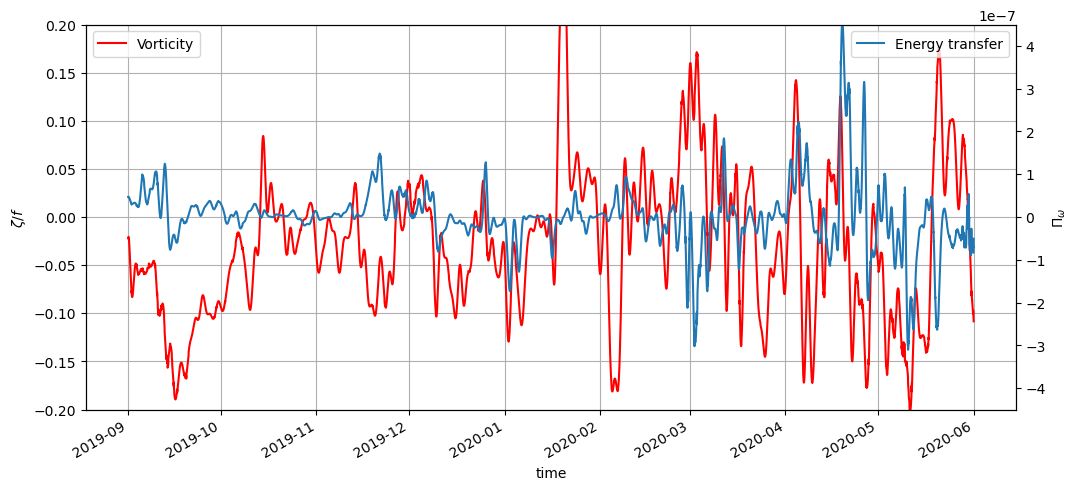

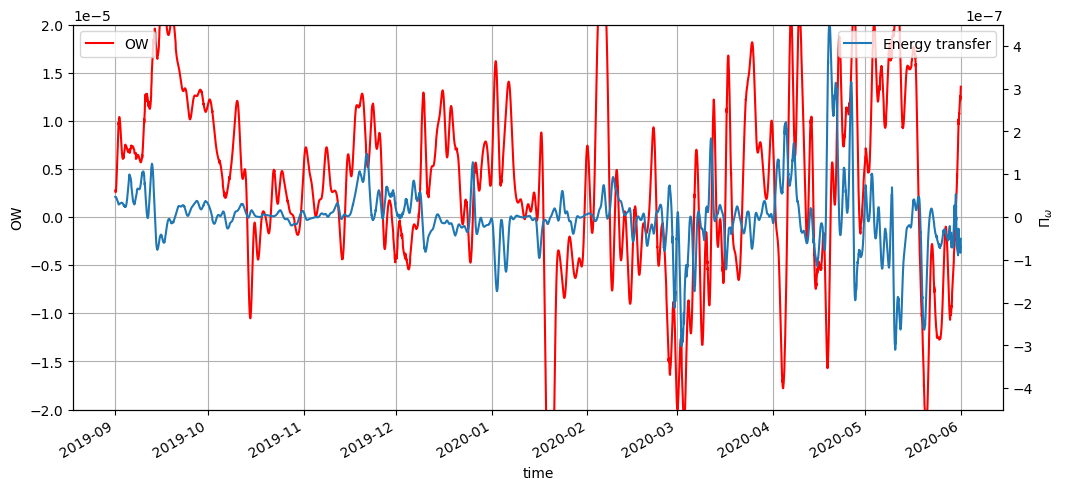

In [157]:
fig,ax=plt.subplots(figsize=(12,5))
(RV_1/fc_1).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='Vorticity')
ax.set_ylim(-0.2,0.2)
ax1=ax.twinx()
P_1.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-4.5e-7,4.5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'$\zeta/f$')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='upper right')

fig,ax=plt.subplots(figsize=(12,5))
(OW_1).sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax,c='r',label='OW')
ax.set_ylim(-2e-5,2e-5)
ax1=ax.twinx()
P_1.sel(time=slice('2019-09','2020-05')).mean('z').plot(ax=ax1,label='Energy transfer')
ax1.set_ylim(-4.5e-7,4.5e-7);ax1.set_ylabel(r'$\Pi_\omega$');ax.set_ylabel(r'OW')
ax.grid();ax.legend(loc='upper left');ax1.legend(loc='upper right')

In [121]:
ds=xr.open_dataset('/Users/zcasparcohen/codes/NIW/'+'data/NI02_M1.nc')

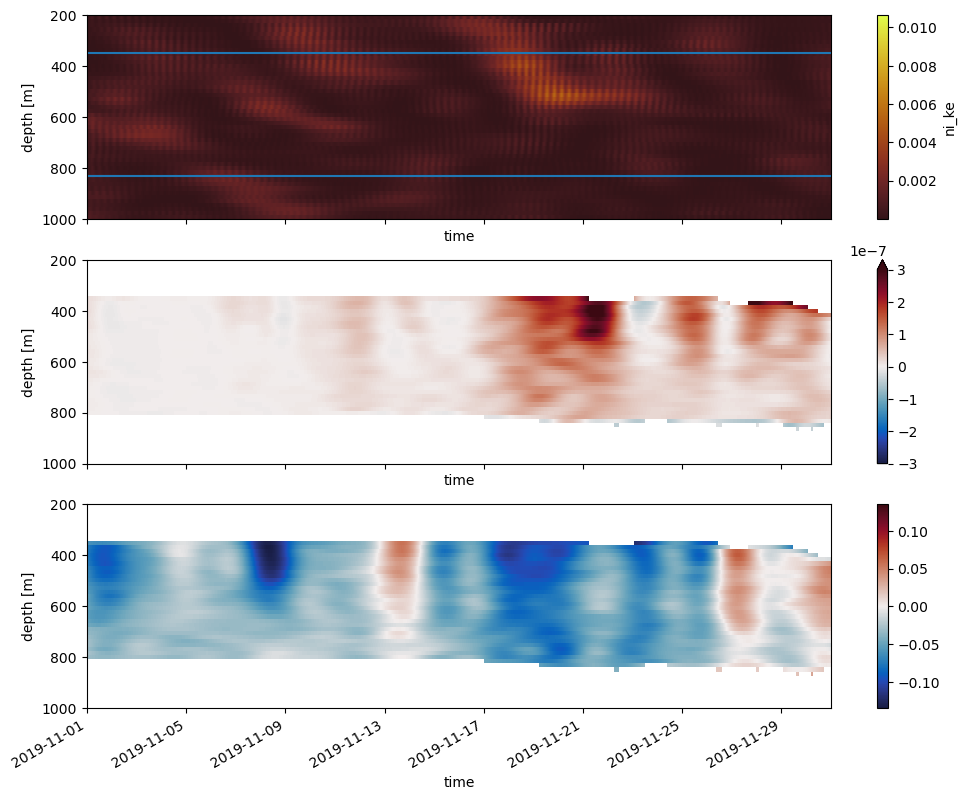

In [163]:
fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='11-2019').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar)
P.sel(time='11-2019').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance)
(RV/fc).sel(time='11-2019').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance)
ax[0].axhline(350);ax[0].axhline(830)

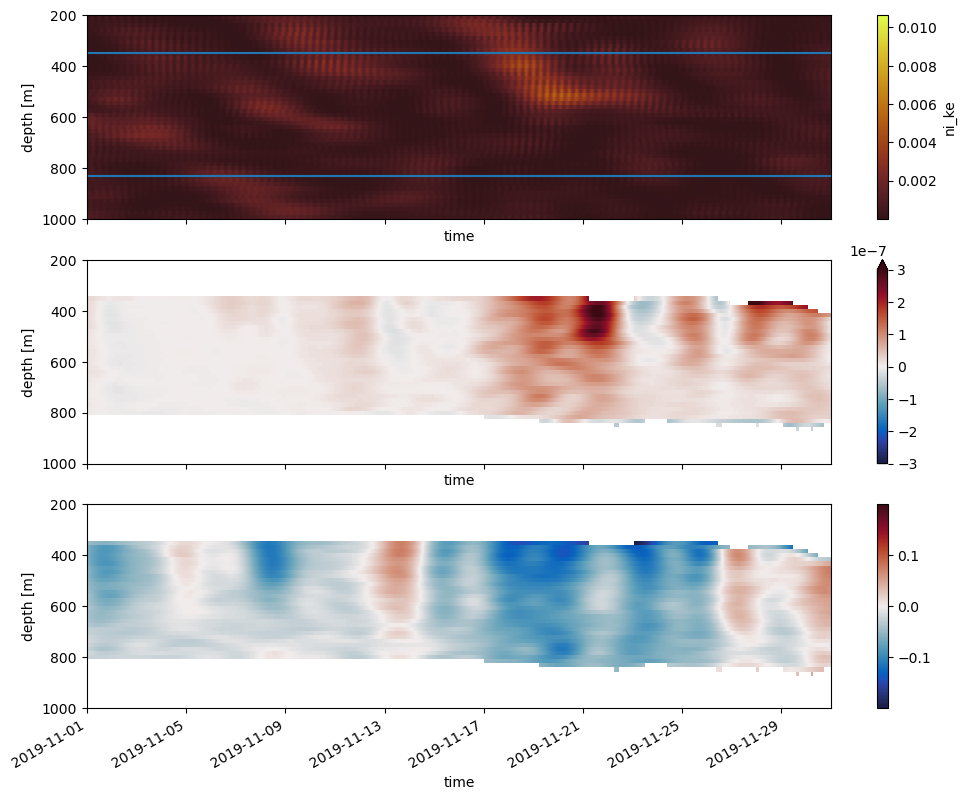

In [164]:
fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='11-2019').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar)
P_1.sel(time='11-2019').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance)
(RV_1/fc_1).sel(time='11-2019').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance)
ax[0].axhline(350);ax[0].axhline(830)

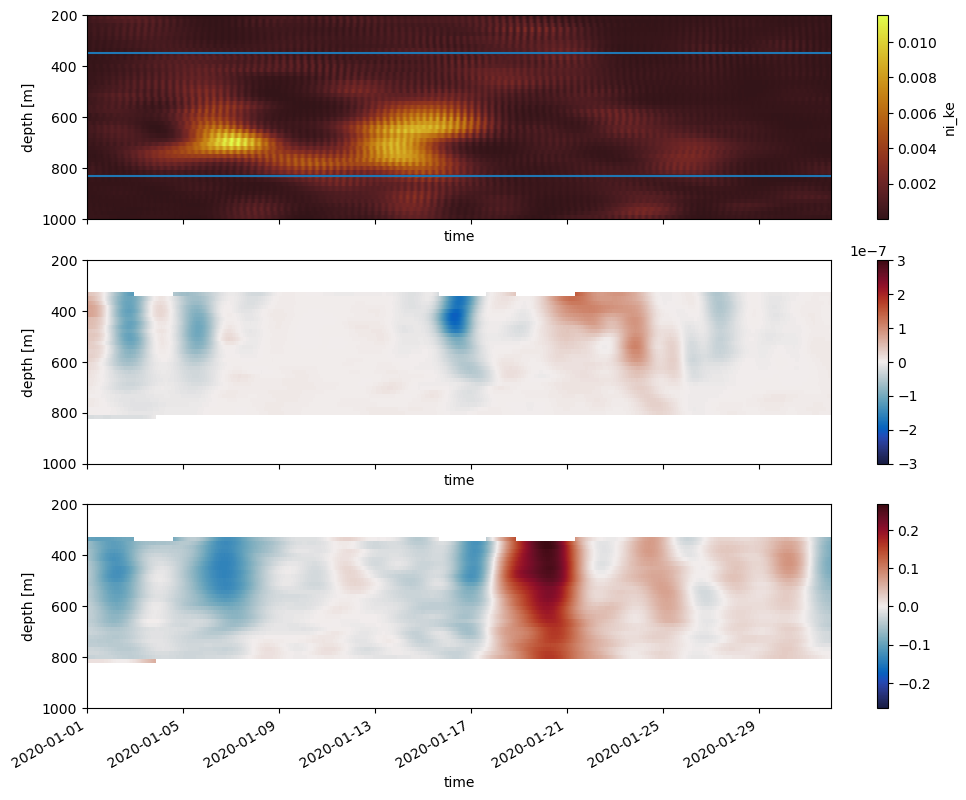

In [167]:
fig,ax=plt.subplots(3,1,figsize=(12,9),sharex=True)
ds.ni_ke.sel(time='01-2020').plot(ax=ax[0],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.solar)
P.sel(time='01-2020').plot(ax=ax[1],yincrease=False,ylim=(1000,200),vmax=3e-7,cmap=cmocean.cm.balance)
(RV/fc).sel(time='01-2020').plot(ax=ax[2],yincrease=False,ylim=(1000,200),cmap=cmocean.cm.balance)
ax[0].axhline(350);ax[0].axhline(830)

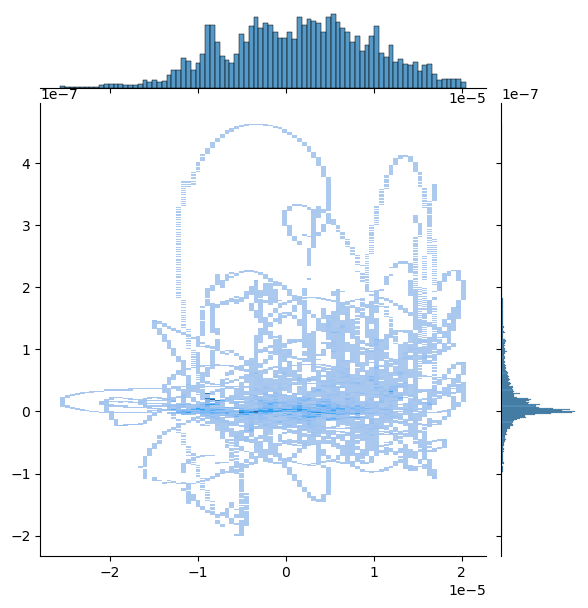

In [161]:
sns.jointplot(x=OW.mean('z').values.flatten(),y=P.mean('z').values.flatten(),kind='hist',stat='density')